**Importing Libraries**

In [ ]:
!pip install alpha_vantage

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


from alpha_vantage.timeseries import TimeSeries

In [ ]:
api_key = "2P18EPAQVSHXBRC6"

In [ ]:
ts = TimeSeries(key =api_key, output_format="pandas")

In [ ]:
df,meta_data = ts.get_daily("TSLA", outputsize="full")
df = df[df.index >= '2015-01-01']
df = df[df.index <= '2025-02-01']

In [ ]:
df

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-01-31,401.53,419.9900,401.3400,404.600,83568219.0
2025-01-30,410.78,412.5000,384.4100,400.280,98092879.0
2025-01-29,395.21,398.5899,384.4800,389.100,68033648.0
2025-01-28,396.91,400.5900,386.5000,398.090,48910676.0
2025-01-27,394.80,406.6900,389.0000,397.150,58125510.0
...,...,...,...,...,...
2015-01-08,212.81,213.7999,210.0100,210.615,3442509.0
2015-01-07,213.35,214.7800,209.7800,210.950,2968390.0
2015-01-06,210.06,214.2000,204.2100,211.280,6261936.0


**Normalize Stock Prices (MinMaxScaler)**

In [ ]:
# Use only the "Close" price for prediction
scaler = MinMaxScaler(feature_range=(0, 1))
df['close_scaled'] = scaler.fit_transform(df[['4. close']])

# Display normalized data
print(df[['4. close', 'close_scaled']].head())


            4. close  close_scaled
date                              
2025-01-31    404.60      0.139159
2025-01-30    400.28      0.137132
2025-01-29    389.10      0.131885
2025-01-28    398.09      0.136104
2025-01-27    397.15      0.135663


**Convert Time Series Data into Sequential Format**

In [ ]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Take 60 days as input
        y.append(data[i+time_steps])    # Predict the next day
    return np.array(X), np.array(y)

# Convert "Close_Scaled" into sequences
time_steps = 60
X, y = create_sequences(df['close_scaled'].values, time_steps)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train (80%) and test (20%)
split = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")


Train Shape: (1980, 60, 1), Test Shape: (496, 60, 1)


In [ ]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop missing values if any
df.dropna(inplace=True)


Missing values:
 1. open         0
2. high         0
3. low          0
4. close        0
5. volume       0
close_scaled    0
dtype: int64


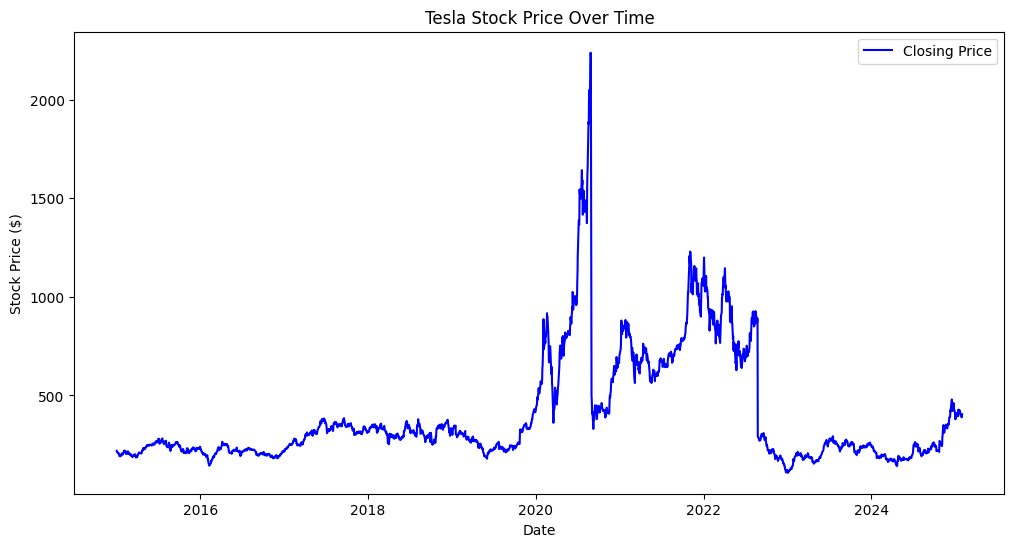

In [ ]:
# Plot Tesla's stock price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['4. close'], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title("Tesla Stock Price Over Time")
plt.legend()
plt.show()


**Moving Averages Analysis**

We'll compute & visualize the 50-day SMA (Simple Moving Average) and 200-day SMA.

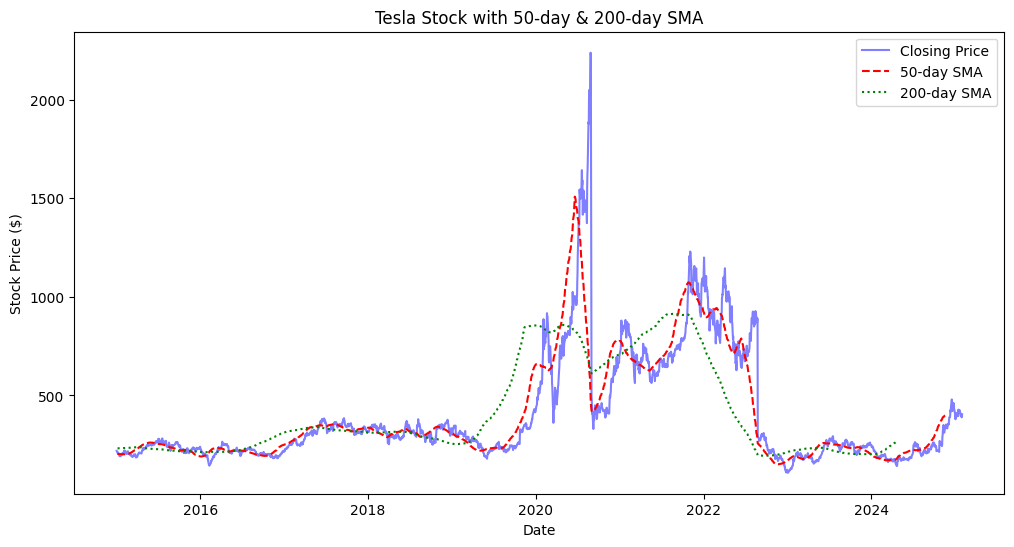

In [ ]:
df['SMA_50'] =df['4. close'].rolling(window=50).mean()
df['SMA_200'] = df['4. close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['4. close'], label="Closing Price", color='blue', alpha=0.5)
plt.plot(df['SMA_50'], label="50-day SMA", linestyle='dashed', color='red')
plt.plot(df['SMA_200'], label="200-day SMA", linestyle='dotted', color='green')
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title("Tesla Stock with 50-day & 200-day SMA")
plt.legend()
plt.show()


**Tesla Stock with 50-day & 200-day SMA**

This plot shows Tesla's stock price along with its 50-day and 200-day Simple Moving Averages (SMA).
The 50-day SMA tracks short-term trends, and the 200-day SMA tracks long-term trends.

Interpretation:

Crossovers between the 50-day and 200-day SMA are important:
If the 50-day SMA crosses above the 200-day SMA, it's a bullish signal (buy).
If the 50-day SMA crosses below the 200-day SMA, it's a bearish signal (sell).
These crossovers are visible in 2020, indicating significant trend reversals.


**Bollinger Bands Analysis**

Bollinger Bands help analyze volatility by plotting an upper and lower band

around a 20-day moving average.

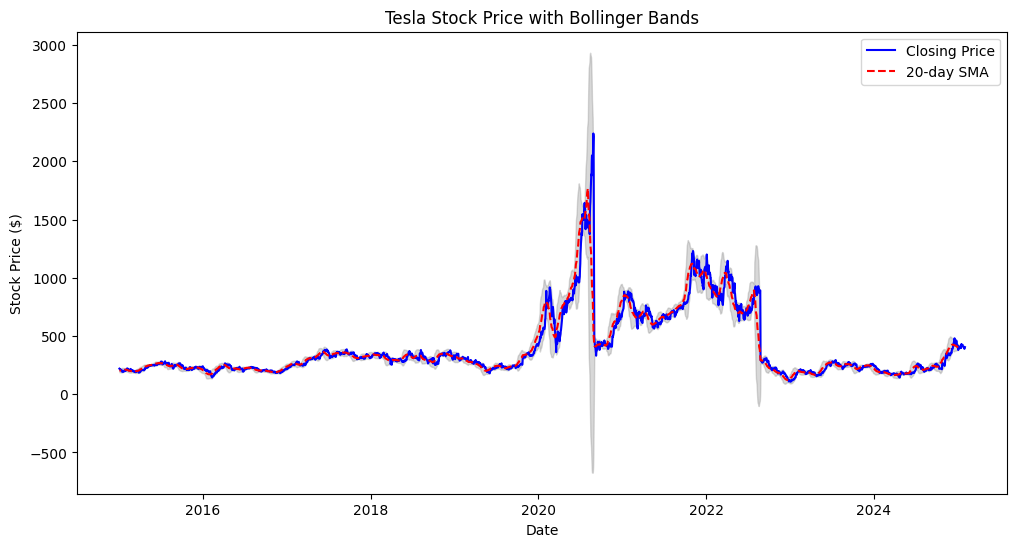

In [ ]:
df['SMA_20'] = df['4. close'].rolling(window=20).mean()
df['Upper_Band'] = df['SMA_20'] + (2 * df['4. close'].rolling(window=20).std())
df['Lower_Band'] = df['SMA_20'] - (2 * df['4. close'].rolling(window=20).std())

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['4. close'], label="Closing Price", color='blue')
plt.plot(df['SMA_20'], label="20-day SMA", linestyle='dashed', color='red')
plt.fill_between(df.index, df['Upper_Band'], df['Lower_Band'], color='gray', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title("Tesla Stock Price with Bollinger Bands")
plt.legend()
plt.show()


**Tesla Stock Price with Bollinger Bands**

Bollinger Bands are added around the 20-day Simple Moving Average (SMA). The bands represent a range where the stock price typically fluctuates.
The upper band is the stock price + 2 standard deviations, and the lower band is the stock price - 2 standard deviations.

Interpretation:

When Tesla’s stock price moves outside the bands (like it does in 2020), it indicates that the price is either overbought (above the upper band) or oversold (below the lower band).
This can signal a potential reversal or a buy/sell opportunity.


**Stock Returns Analysis**

We'll calculate daily returns to analyze stock volatility.

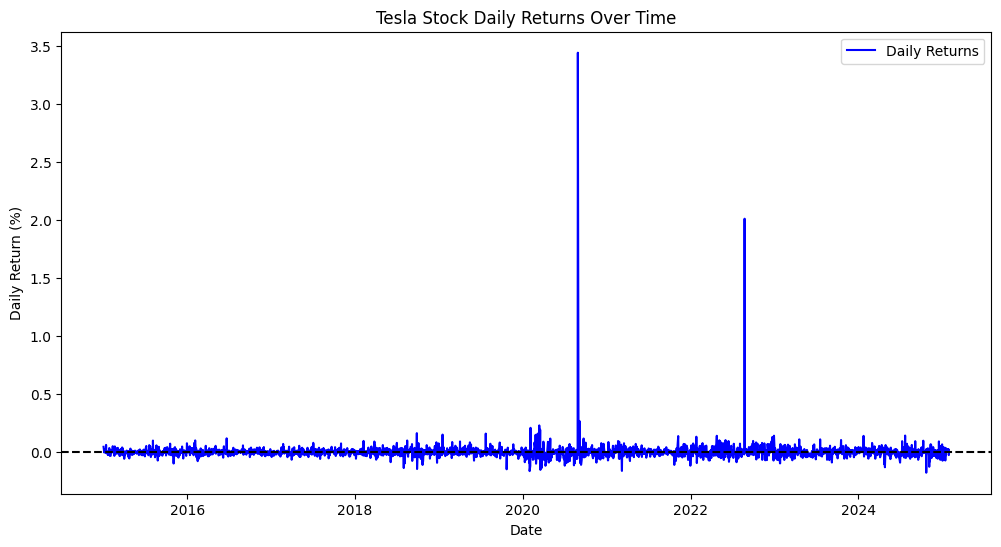

In [ ]:
# Compute daily returns
df['Daily_Return'] =  df['4. close'].pct_change()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily_Return'], label="Daily Returns", color='blue')
plt.axhline(y=0, linestyle='dashed', color='black')
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.title("Tesla Stock Daily Returns Over Time")
plt.legend()
plt.show()


**Tesla Stock Daily Returns Over Time**

This plot tracks daily returns for Tesla’s stock, calculated as the percentage
change from one day to the next.

Interpretation:
Most of the daily returns are small fluctuations around zero, showing that Tesla's stock usually moves gradually.However, you can see large spikes in daily returns, particularly during the years 2020-2021. These could indicate major events or announcements affecting Tesla's stock price.

**Seasonal Analysis**

We'll check if Tesla's stock price follows any seasonal trends.

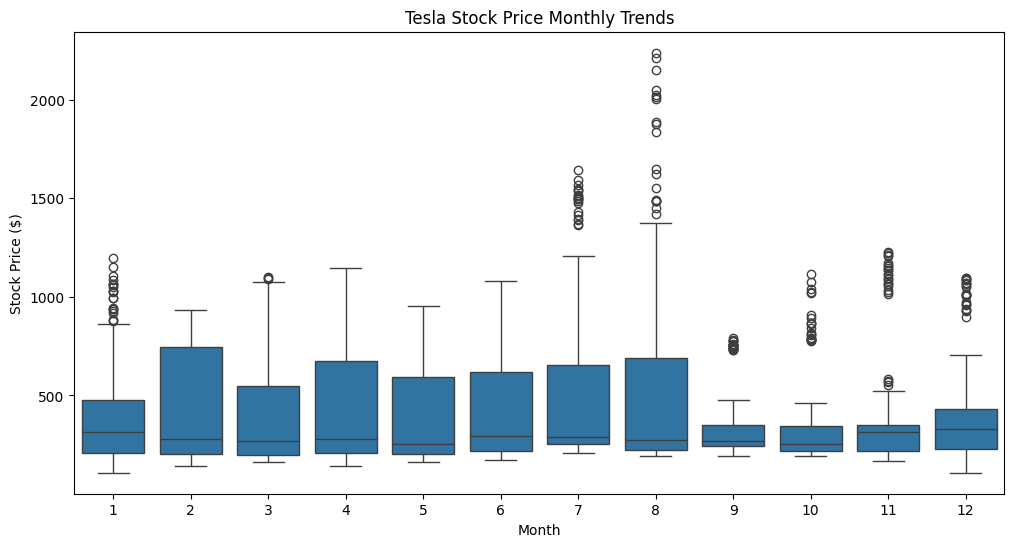

In [ ]:
# Extract month and year
df['Month'] = df.index.month
df['Year'] = df.index.year

# Boxplot to visualize monthly trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='4. close', data=df)
plt.title("Tesla Stock Price Monthly Trends")
plt.xlabel("Month")
plt.ylabel("Stock Price ($)")
plt.show()



**Tesla Stock Price Monthly Trends**

This boxplot visualizes the distribution of Tesla’s stock prices by month.
Each box represents the stock price variation within each month, with outliers shown as dots.

Interpretation:

The plot reveals which months Tesla's stock typically performs better (e.g., higher median values) or worse (e.g., lower median values).
It also shows significant volatility during certain months, such as spikes in stock prices.

**Build the LSTM Model**

We now build an LSTM model to predict Tesla's stock price.

In [ ]:
# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Predict 1 future price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0118 - val_loss: 1.4583e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0021 - val_loss: 5.4622e-05
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0019 - val_loss: 2.0544e-05
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0018 - val_loss: 8.4813e-05
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0016 - val_loss: 1.3738e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0019 - val_loss: 1.6165e-05
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0013 - val_loss: 2.1330e-05
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 9.3430e-04 - val_loss: 2.8937e-05
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.3581e-04 - val_loss: 1.6638e-05
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0012 - val_loss: 2.2780e-05
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0012 - val_loss: 1.2479e-04
Epoch 12/50

**Model Evaluation**

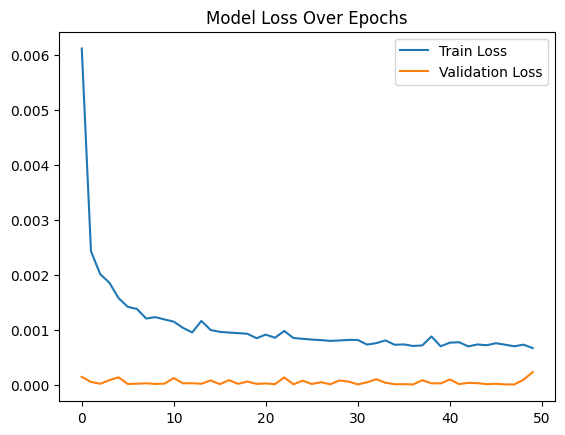

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()


**Model Loss Over Epochs**

This plot shows the training loss (blue line) and validation loss (orange line) over the course of training.
The train loss indicates how well the model is fitting the training data.
The validation loss shows how well the model generalizes to unseen data.

Interpretation:

Initially, both losses are high, but they steadily decrease, indicating that the model is learning.
The model's loss plateaus after a certain number of epochs, which means it has learned the patterns in the data and doesn't improve further.

**Make Predictions**

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


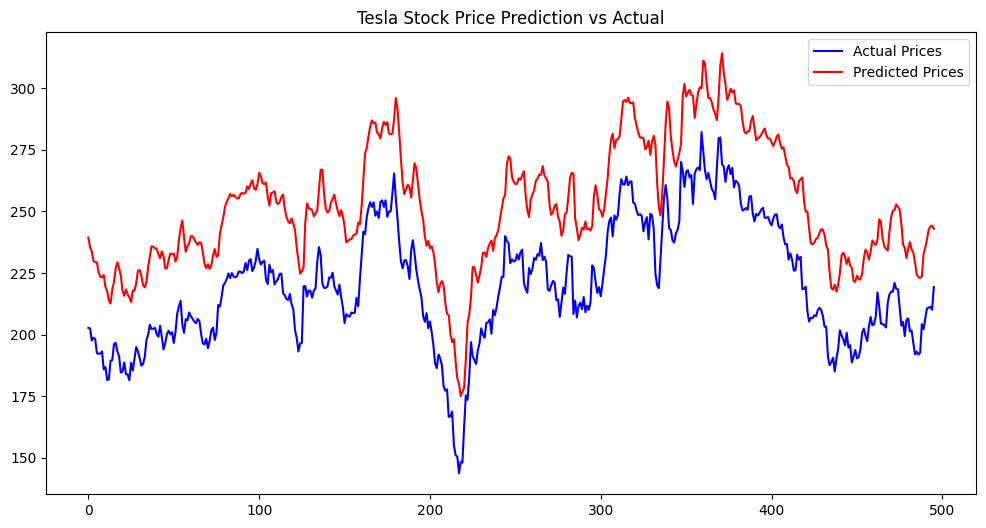

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert back to actual stock prices
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(y_pred_actual, label="Predicted Prices", color='red')
plt.legend()
plt.title("Tesla Stock Price Prediction vs Actual")
plt.show()


**Tesla Stock Price Prediction vs Actual**


This plot compares the actual stock prices (blue line) with the predicted stock prices (red line) of Tesla.
We can observe how closely the model's predictions align with the actual price movements.

Interpretation:

The model does a decent job of capturing the overall stock price trend, but there are times when it fails to match the exact peaks and troughs.

**Future Predictions**

In [ ]:
# Get last 60 days from the dataset
last_60_days = df['close_scaled'].values[-60:].reshape(1, -1, 1)

# Predict next day's stock price
future_price = model.predict(last_60_days)

# Convert back to original price scale
future_price_actual = scaler.inverse_transform(future_price.reshape(-1, 1))
print(f"Predicted Tesla Stock Price for Next Day: ${future_price_actual[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Tesla Stock Price for Next Day: $249.21
